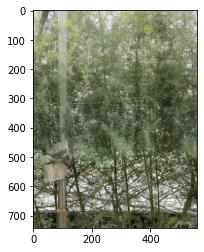

In [183]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def show(image):
    plt.imshow(image)
    plt.show()

start = time.time()

"""
Load images
"""
input_name = "data/leaf.jpg"
leaf_image = cv2.imread(input_name)
# leaf_image = cv2.imread("data/leaf2.png")
leaf_image = cv2.resize(leaf_image, None, fx=0.2, fy=0.2)
leaf_image_raw = leaf_image
leaf_image_rgb = cv2.cvtColor(leaf_image, cv2.COLOR_BGR2RGB)
show(leaf_image_rgb)

# 色空間の変換(RGB -> CIE LCh)

In [184]:
from skimage.color import rgb2lab, lab2lch

img_lab = rgb2lab(leaf_image_rgb)
img_lch = lab2lch(img_lab)

# LCh色空間を用いた色検出(1段階目の色成分フィルタリング)

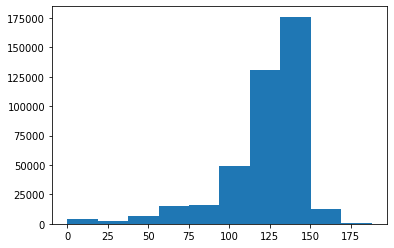

330060


In [185]:
bgrLower = np.array([0, 110, 0])
bgrUpper = np.array([255, 170, 255])
img_lch[:, :, 1] = (255 * np.log10(img_lch[:, :, 1] + 1) / np.log10(255)).astype(np.uint8)  # perceptual color spaces
lsh_mask = cv2.inRange(img_lch, bgrLower, bgrUpper)
lsh_mask = cv2.resize(lsh_mask, leaf_image.shape[-2::-1])
plt.hist(img_lch[:,:,1].reshape(-1))
plt.show()
print(np.sum(lsh_mask > 0))

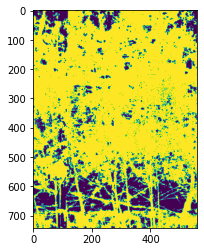

In [186]:
show(lsh_mask)

# 緑成分優位な画像成分の抽出(2段階目の色成分フィルタリング)

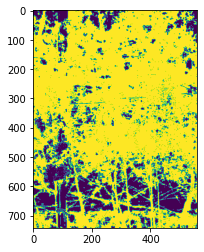

91854


In [187]:
leaf_image_float = leaf_image.astype(np.float64) / 255
leaf_image_float += 10e-8
lsh_where = np.where(lsh_mask == 0)
leaf_image_float[lsh_where[0], lsh_where[1], :] = (1.0, 0.1, 1.0)
is_green_dominant = (np.max(leaf_image_float[:, ..., :] / leaf_image_float[:, :, 1][:, :, np.newaxis], axis=2) > 1.0) & (
    np.max(leaf_image_float, axis=2) > 0.5
)
mask_green_dominant = np.zeros_like(is_green_dominant, np.uint8)
mask_green_dominant[is_green_dominant] = 255

show(255 - mask_green_dominant)  # yellow:255 black:0
print(np.sum(mask_green_dominant > 0))

# 疑似葉面積密度画像の非緑優位画像成分用マスクの生成

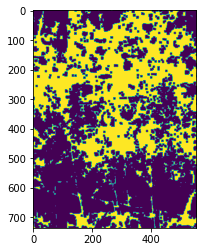

241174


In [188]:
patch_size = 7
size_pooled = np.array(mask_green_dominant.shape) - [patch_size - 1, patch_size - 1]
patches = extract_patches_2d(mask_green_dominant, (patch_size, patch_size))
mask_green_dominant_with_pooling = (np.max(patches.reshape((-1, patch_size ** 2)), axis=-1)).reshape(size_pooled)
mask_green_dominant_with_pooling = mask_green_dominant_with_pooling.astype(np.uint8)

show(255 - mask_green_dominant_with_pooling)  # yellow:255 black:0
print(np.sum(mask_green_dominant_with_pooling > 0))


# 局所画像パッチ毎の疑似葉面積密度の取得

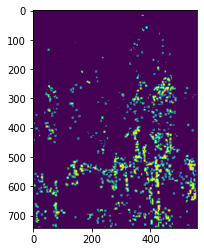

In [189]:
from sklearn.feature_extraction.image import extract_patches_2d


def get_density(patch_flattened):
    return np.sum(patch_flattened) / len(patch_flattened)

green_relative_intensity = np.max(leaf_image_float[:, :, 1][:, :, np.newaxis] / leaf_image_float[:, ..., :], axis=2)
patches_gri = extract_patches_2d(green_relative_intensity, (patch_size, patch_size)).reshape(-1, patch_size ** 2)

mask_gri = np.apply_along_axis(get_density, 1, patches_gri).reshape(size_pooled)
# gri_quant_l = np.quantile(mask_gri.reshape(-1), 0.50)
# gri_quant_u = np.quantile(mask_gri.reshape(-1), 0.90)
gri_quant_l = 1
gri_quant_u = 30000
mask_gri[mask_gri < gri_quant_l] = gri_quant_l
mask_gri[mask_gri >= gri_quant_u] = gri_quant_u
mask_gri_normalized = (mask_gri - mask_gri.min()) / (mask_gri.max() - mask_gri.min())
mask_gri_normalized[mask_green_dominant_with_pooling == 0] = 0
mask_gri_normalized = cv2.copyMakeBorder(
    mask_gri_normalized, patch_size // 2, patch_size // 2, patch_size // 2, patch_size // 2, cv2.BORDER_CONSTANT, 0
)
show(mask_gri_normalized)


# 画像スムージング（ガイデッドフィルタ）

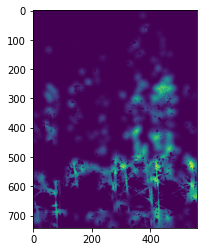

In [190]:
from guided_filter.core.filter import GuidedFilter

GF = GuidedFilter(leaf_image, 8, 0.4 ** 2)
mask_gri_normalized = GF.filter(mask_gri_normalized)
mask_gri_normalized[mask_gri_normalized < 0] = 0
mask_gri_normalized[mask_gri_normalized >= 1.0] = 1.0
mask_gri_normalized[lsh_mask == 0] = 0
show(mask_gri_normalized)

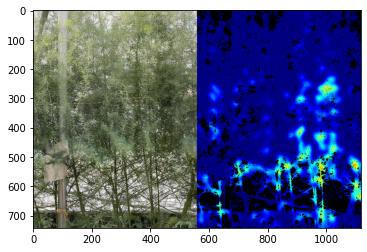

total elapsed time [s]:11.0106680393219


In [191]:
from PIL import Image


def cv2pil(image):
    new_image = image.copy()
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = Image.fromarray(new_image)
    return new_image


def concat_horizontal(ims):
    h = max(im.height for im in ims)
    w = sum(im.width for im in ims)

    dst = Image.new("RGB", (w, h))
    _w = 0
    for im in ims:
        dst.paste(im, (_w, 0))
        _w += im.width
    return dst


mask_gri_colorized = cv2.applyColorMap((mask_gri_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)
mask_gri_colorized[lsh_where[0], lsh_where[1], :] = (0, 0, 0)
show(concat_horizontal([cv2pil(leaf_image), cv2pil(mask_gri_colorized)]))

end = time.time()
print("total elapsed time [s]:{}".format(end-start))